In [17]:
import numpy as np
import math
from matplotlib import pyplot as plt
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)
%matplotlib inline
!pip install py_vollib 
import py_vollib
from py_vollib.black_scholes  import black_scholes as bs
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv

In [18]:
# stocks are all martingales.
mu1 = 0;
sigma1 = 0.2;
mu2 = 0;
sigma2= 0.6;
r = 0; 

# time increment
dt = 0.05*1/365;
 
maturity = np.arange(1,3000,10);#% 1:10:2000;
maturity_len = len(maturity);
maturity_max = maturity[-1]; #Get the last element


#derivative of implied vol at ATM
derivative = np.zeros(maturity_len)-10;

#simulate many paths 
num_paths = 50000;

# small number
eps = 0.001;

stock1_paths = np.zeros((num_paths,maturity_max));
stock2_paths = np.zeros((num_paths, maturity_max));

index = np.zeros((num_paths, maturity_max));


# initial values
S0stock1=100;
S0stock2=97;
stock1_paths[:,0] = S0stock1;
stock2_paths[:,0] = S0stock2;


# weights for index
w1 = 0.6; 
w2 = 0.4; 
index[:,0] = w1*stock1_paths[0,0]+ w2*stock2_paths[0,0];


MaturityT=dt*maturity_max; # time to maturity
ndt=math.floor(1/dt); #round 1/dt to an integer

#simulate GBMs
noise1 =  np.sqrt(dt)*np.random.normal(0,1,size=(num_paths,maturity_max));
noise2 =  np.sqrt(dt)*np.random.normal(0,1,size=(num_paths,maturity_max));

W1 = np.cumsum(noise1, axis = 1);
W2 = np.cumsum(noise2, axis = 1);


#simulate stock pths
TT0 = np.multiply(dt,list(range(1,maturity_max+1,1)));
X1 = W1 - 0.5* sigma1**2*TT0;
X2 = W2 - 0.5* sigma2**2*TT0;

#GBMs
#for p in range(0,num_paths):
    #stock1_paths[p,1:(maturity_max)]= S0stock1 * np.exp(sigma1*W1[p,1:(maturity_max)] - 0.5* sigma1**2*TT0);
    #stock2_paths[p,1:(maturity_max)]= S0stock1 * np.exp(sigma2*W2[p,1:(maturity_max)] - 0.5* sigma2**2*TT0);
stock1_paths[:,1:(maturity_max)]= S0stock1 * np.exp(sigma1*X1[:,0:(maturity_max-1)]);
stock2_paths[:,1:(maturity_max)]= S0stock2 * np.exp(sigma2*X2[:,0:(maturity_max-1)]);


    

In [14]:
np.mean(stock2_paths[:,maturity_max-1])

101.10720421669227

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


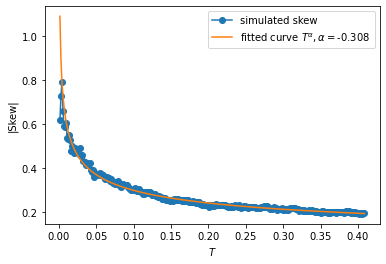

In [19]:
#initiate stocks array
stocks=np.zeros((num_paths,2));

for j in range(1,maturity_max-1):  #range must be 1---> to end here
 #Compute index
 #stocks=np.array([stock1_paths[p,j],stock2_paths[p,j]])
 stocks[:,0]=stock1_paths[:,j];
 stocks[:,1]=stock2_paths[:,j];
 #descending sort
 stocks=-stocks;
 stocks.sort();
 stocks=-stocks;
 #call on index
 index[:,j]=w1*stocks[:,0]+w2*stocks[:,1];
 #index[:,j] = stock1_paths[:,j]

#derivative of implied vol at ATM
derivative = np.zeros((1,maturity_len));

ATM_implied_vol = np.zeros((1,maturity_len));

# compute index_hat = E[index_{maturity}|F_0],
# which is the price of index future at 0
index_hat = np.zeros((1,maturity_len));

for m in range(0,maturity_len-1):
  index_hat[0,m]=np.mean(index[:,maturity[m]])

for m in range(0,maturity_len-1):
  #compute option price
  #%ATM strike is the price of index future with matrutity maturity(1,m)
  I = index_hat[0,m];
  #I = stock1_paths[0,0];
  #% consider two strikes only
  strike =np.zeros((1,2))
  strike[0,0]=I-eps;
  strike[0,1]=I;# [I-eps I];
  log_moneyness =np.log(strike/I);
  strike_len = np.max(strike.shape);
  implied_vol =np.zeros((1,strike_len));
  call_price_list = np.zeros((1,strike_len));

  #% time to maturity
  TT = maturity[m]*dt;

  for s in range(0,strike_len):
    #% index option price using Monte Carlo
    payoff_index = index[:,maturity[m]] - strike[0,s];
    payoff_index = payoff_index[payoff_index > 0];
    index_call_price = np.sum(payoff_index)/num_paths;
    #%Volatility = blsimpv(Price,Strike,Rate,Time,Value)
    #% compute implied vol, price is now index_hat
    implied_vol[0,s] = iv(index_call_price,I,strike[0,s],maturity[m]*dt,0,'c'); #imp_v = iv(price, S, K, t, r, flag='c','p')
    #call_price_list[0,s] = index_call_price ;
    #% implied vol at ATM
    if strike[0,s] == I:
      ATM_implied_vol[0,m] = iv(index_call_price,I,strike[0,s],TT,0,'c');
  # discret time derivative of implied vol
  #derivative[0,m] = (implied_vol[0,0] - implied_vol[0,1])/(log_moneyness[0,1] - log_moneyness[0,0]);
  derivative[0,m] = (implied_vol[0,0] - implied_vol[0,1])/(log_moneyness[0,0] - log_moneyness[0,1]);


#Fit the Power Regression Model
# this gives quasi blow up
p = np.polyfit(np.log(maturity[3:(maturity_len-1)]*dt),np.log(np.abs(derivative[0,3:(maturity_len-1)])),1);
m_fit = round(p[0],4);
b_fit = np.exp(p[1]);
plt.plot(maturity[1:(maturity_len-1)]*dt,np.abs(derivative[0,1:(maturity_len-1)]),'o-',label='simulated skew');
plt.plot(maturity[1:(maturity_len-1)]*dt,b_fit*(maturity[1:(maturity_len-1)]*dt)**(m_fit),label=r"fitted curve $T^\alpha,\alpha=$"+ str(m_fit));
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel("|Skew|")
plt.savefig('GBM_2stocks_quasi.eps', format='eps')
plt.show()


